# Human LUAS

## import necessary packages for CauFinder

In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
from math import ceil, floor
from typing import Dict, List, Optional, Union
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from statistics import stdev
from numpy import nanstd, isnan, nan
import random
from scipy import linalg
import torch
from anndata import AnnData, concat
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from CauFinder.dataloader import zscore_normalization, apply_activation
from CauFinder.benchmark import run_caufinder121
import chardet
from CauFinder.caufinder_main import CausalFinder
from CauFinder.benchmark import cumulative_weight_sum_rate
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.decomposition import PCA
from CauFinder.utils import set_seed, plot_feature_boxplots, merge_basic_driver, merge_complex_driver
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from CauFinder.utils import load_luas_human_adata, human_all_adata, human_data_direction, calculate_w1_w2, find_index
from CauFinder.utils import result_add_direction, plot_control_scores, plot_control_scores_by_category
from CauFinder.utils import plot_3d_state_transition, plot_causal_feature_transitions
import umap

import scanpy as sc
import pickle as pkl
import collections as ct
import warnings

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/tmp/ipykernel_56449/4004712460.py:15: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy import linalg
2024-08-13 03:47:37.644722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 03:47:37.871158: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results d

## set for figure saving

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'

## Set path for read files and save output

In [3]:

BASE_DIR = "./CauFinder-master"
case_dir = os.path.join(BASE_DIR, 'LUAS', 'human')
data_path = os.path.join(case_dir, 'data')
output_path = os.path.join(case_dir, 'output', 'final_model')
os.makedirs(output_path, exist_ok=True)

tf_path = os.path.join(BASE_DIR, 'resources', 'tf', 'hs_hgnc_tfs_lambert2018.txt')
network_path = os.path.join(BASE_DIR, 'resources', 'network', 'NicheNet_human.csv')
tf_list = pd.read_csv(tf_path, header=None, squeeze=True).tolist()
prior_network = pd.read_csv(network_path, index_col=None, header=0)
adata, adata_filter = load_luas_human_adata(data_dir=data_path, tf_list=tf_list)


##  run CauFinder

In [4]:
# We recommend using the pre-trained drivers obtained after 100 runs of training.
# Set to True if you want to train the model from scratch
train_new_model = False  # Default is to load the pre-trained model

if train_new_model:
    # Initialize and train the model from scratch
    model = CausalFinder(
        adata=adata,
        n_latent=25,
        n_causal=5,
        n_hidden=128,
        n_layers_encoder=0,
        n_layers_decoder=0,
        n_layers_dpd=0,
        dropout_rate_encoder=0.0,
        dropout_rate_decoder=0.0,
        dropout_rate_dpd=0.0,
        use_batch_norm='none',
        use_batch_norm_dpd=True,
        pdp_linear=True,
    )
    model.train(max_epochs=400, stage_training=True)

    # SHAP
    weight_shap_total, weight_shap_full = model.get_feature_weights(sort_by_weight=True, method="SHAP")
    weight_shap_0, weight_shap_1 = model.get_class_weights(weight_shap_full, sort_by_weight=True)
    # Grad
    weight_grad_total, weight_grad_full = model.get_feature_weights(sort_by_weight=True, method="Grad")
    weight_grad_0, weight_grad_1 = model.get_class_weights(weight_grad_full, sort_by_weight=True)
    # Class driver (SHAP or Grad for each class)
    driver_df = model.network_master_regulators(prior_network, weight_shap_total, corr_cutoff=0.7, out_lam=1.0, ILP_lam=0.5)
    driver_total = driver_df[driver_df['is_CauFVS_driver']].index.tolist()
    driver_df = model.network_master_regulators(prior_network, weight_shap_0, corr_cutoff=0.7, out_lam=1.0, ILP_lam=0.5)
    driver_0 = driver_df[driver_df['is_CauFVS_driver']].index.tolist()
    driver_df = model.network_master_regulators(prior_network, weight_shap_1, corr_cutoff=0.7, out_lam=1.0, ILP_lam=0.5)
    driver_1 = driver_df[driver_df['is_CauFVS_driver']].index.tolist()

    driver_info = merge_basic_driver(driver_total, driver_0, driver_1, weight_shap_total, weight_shap_0, weight_shap_1)
    driver_info['weight_total'] = weight_grad_total.loc[driver_info.index, 'weight_dir']  # Direction for all samples
    driver_info['direction_0'] = weight_grad_0.loc[driver_info.index, 'weight_dir']  # Direction for Class 0
    driver_info['direction_1'] = weight_grad_1.loc[driver_info.index, 'weight_dir']  # Direction for Class 1
    drivers = driver_total
else:
    # Define model path
    model_path = os.path.join(data_path, '_seed60.pkl')
    # Load pre-trained model and driver info
    with open(model_path, 'rb') as file:
        model = pkl.load(file)

    driver_info_path = os.path.join(output_path, 'driver_summary_shap_total.csv')
    driver_info = pd.read_csv(driver_info_path, index_col=0)
    filtered_driver_info = driver_info[driver_info['counts'] > 30]

    drivers = filtered_driver_info.index.to_list()

## plot PCA with probabilities 

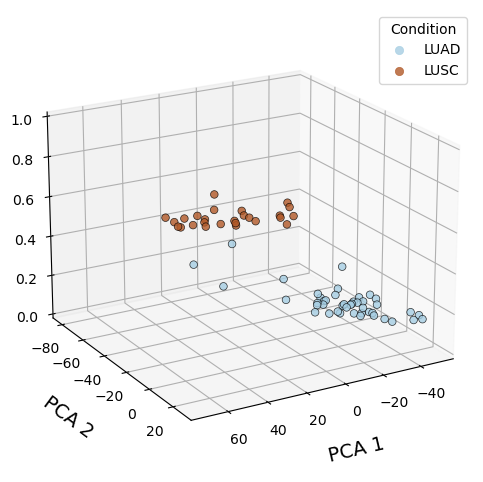

In [6]:
adata_filter.obs['probs'] = model.get_model_output()['probs']
model.plot_pca_with_probs(adata_filter, save_dir=output_path, elev=20, azim=60)

## run state transition

### transition from 0 -> 1

In [9]:
adata_increase = model.guided_state_transition(
    adata=adata_filter,
    causal_features=drivers,
    lambda_reg=1e-6,
    lr=0.1,
    max_iter=300,
    # stop_thresh=0.0,
    target_state=1,
    # iter_norm=False,
)

Processing sample 0, Target direction: increase
Processing sample 1, Target direction: increase
Processing sample 2, Target direction: increase
Processing sample 3, Target direction: increase
Processing sample 4, Target direction: increase
Processing sample 5, Target direction: increase
Processing sample 6, Target direction: increase
Processing sample 7, Target direction: increase
Processing sample 8, Target direction: increase
Processing sample 9, Target direction: increase
Processing sample 10, Target direction: increase
Processing sample 11, Target direction: increase
Processing sample 12, Target direction: increase
Processing sample 13, Target direction: increase
Processing sample 14, Target direction: increase
Processing sample 15, Target direction: increase
Processing sample 16, Target direction: increase
Processing sample 17, Target direction: increase
Processing sample 18, Target direction: increase
Processing sample 19, Target direction: increase
Processing sample 20, Target d

### increasing state transition on PCs for sample0

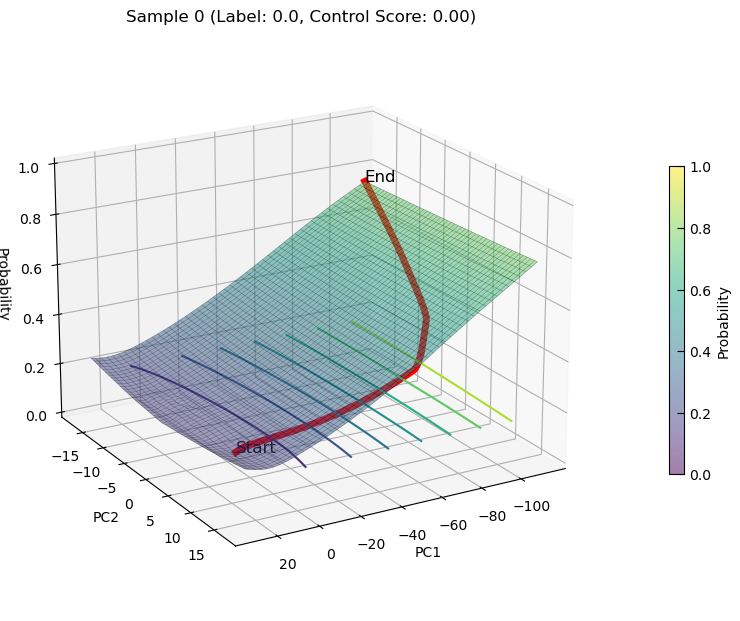

In [13]:
plot_3d_state_transition(adata_increase, sample_indices=[0], use_pca=True, elev=20, azim=60)

### transition from 1 -> 0

In [14]:
adata_decrease = model.guided_state_transition(
    adata=adata_filter,
    causal_features=drivers,
    lambda_reg=1e-6,
    lr=0.1,
    max_iter=300,
    # stop_thresh=0.0,
    target_state=0,
    # iter_norm=False,
)

Processing sample 0, Target direction: decrease
Processing sample 1, Target direction: decrease
Processing sample 2, Target direction: decrease
Processing sample 3, Target direction: decrease
Processing sample 4, Target direction: decrease
Processing sample 5, Target direction: decrease
Processing sample 6, Target direction: decrease
Processing sample 7, Target direction: decrease
Processing sample 8, Target direction: decrease
Processing sample 9, Target direction: decrease
Processing sample 10, Target direction: decrease
Processing sample 11, Target direction: decrease
Processing sample 12, Target direction: decrease
Processing sample 13, Target direction: decrease
Processing sample 14, Target direction: decrease
Processing sample 15, Target direction: decrease
Processing sample 16, Target direction: decrease
Processing sample 17, Target direction: decrease
Processing sample 18, Target direction: decrease
Processing sample 19, Target direction: decrease
Processing sample 20, Target d

### decreasing state transition on PCs for sample68

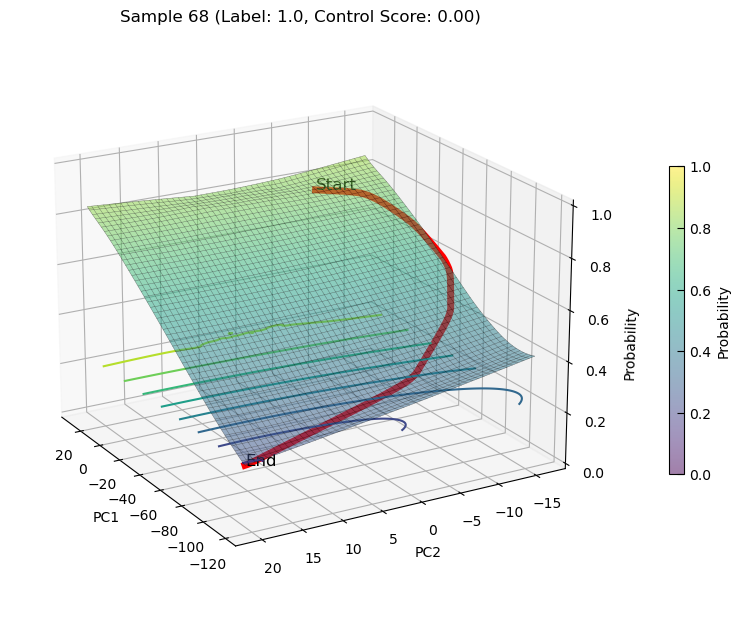

In [22]:
plot_3d_state_transition(adata_decrease, sample_indices=[68], use_pca=True, elev=20, azim=150)

### saving state transition

In [ ]:
with open(os.path.join(output_path, 'adata_increase.pkl'), 'wb') as file:
    pkl.dump(adata_increase, file)
with open(os.path.join(output_path, 'adata_decrease.pkl'), 'wb') as file:
    pkl.dump(adata_decrease, file)

## drawing state transition score on PCA

### PCA plot for data

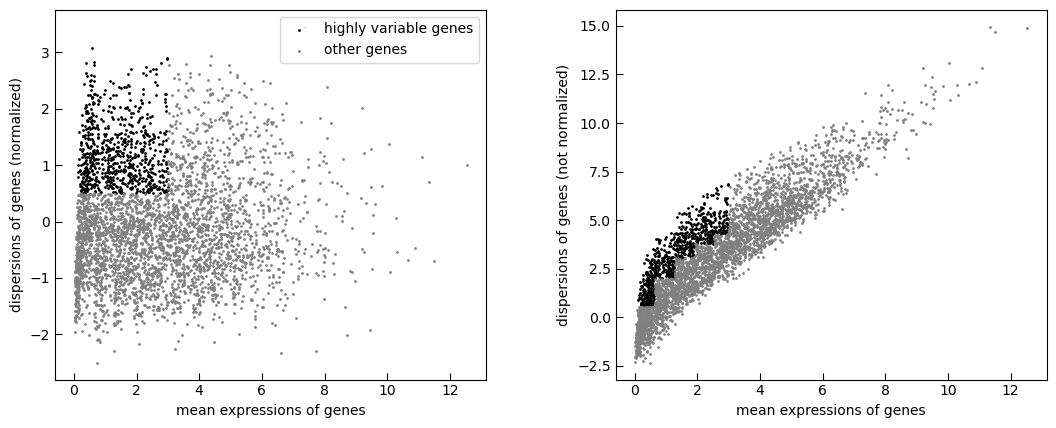

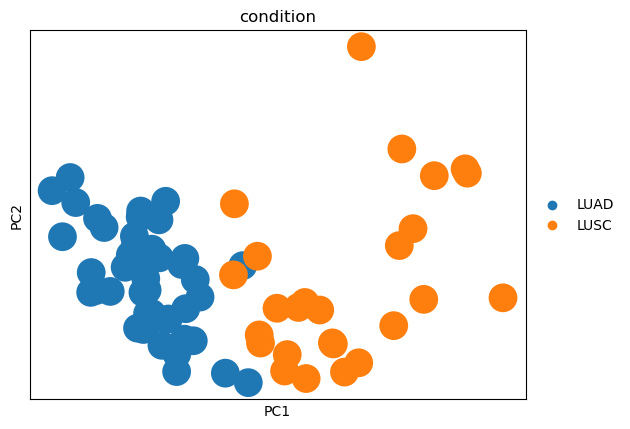

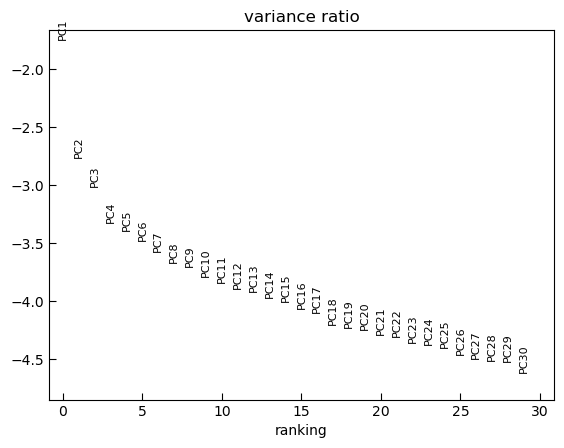

In [74]:
test_adata = adata_filter.copy()
sc.pp.highly_variable_genes(test_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(test_adata)

test_adata.raw = test_adata
test_adata = test_adata[:, test_adata.var.highly_variable]
sc.tl.pca(test_adata, svd_solver="arpack", n_comps=30)
sc.pl.pca(test_adata, color='condition')
sc.pl.pca_variance_ratio(test_adata, log=True)
sc.pp.neighbors(test_adata, n_neighbors=10, n_pcs=10)

### color with state transition score

In [28]:
# color with increase score
df1 = test_adata.obs
df2 = adata_increase.uns['control_details']
df2['sample_idx'] = pd.Series([str(i) for i in df2['sample_idx']], dtype="category", name='sample_idx', index=df2.index.to_list())
df2.index = df1.index

test_adata.obs = pd.concat([df1, df2], axis=1)


/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


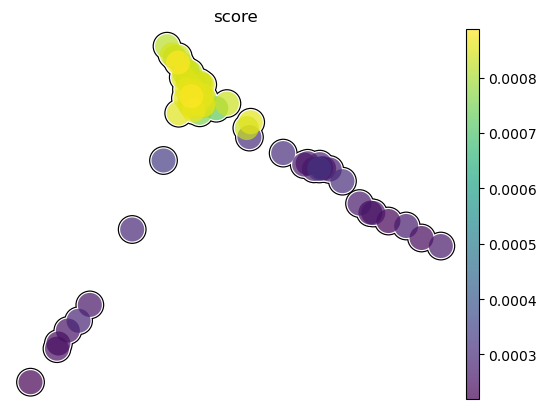

In [137]:
# increase score
sc.pl.umap(test_adata, color='score', legend_loc="on data", size=1200, legend_fontsize=16, palette="Set2",
           frameon=False, add_outline=True, outline_width=(0.05, 0.05))

### mark on condition and sample ID

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


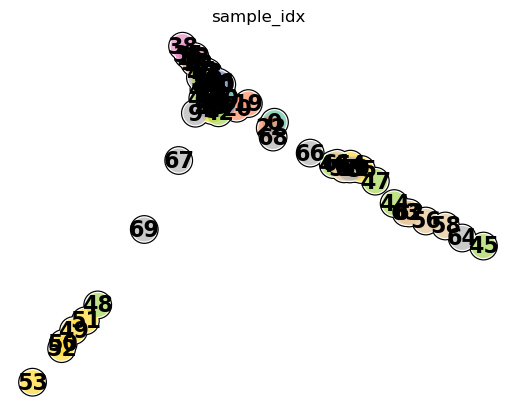

In [136]:
sc.pl.umap(test_adata, color='sample_idx', legend_loc="on data", size=1200, legend_fontsize=16, palette="Set2",
           frameon=False, add_outline=True, outline_width=(0.05, 0.05))

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


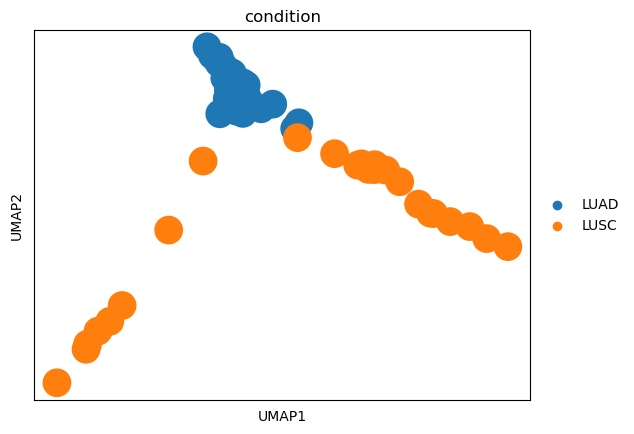

In [131]:
sc.pl.umap(test_adata, color='condition', size=1200, legend_fontsize=16,
           frameon=False, add_outline=True, outline_width=(0.05, 0.05))

### mark on genes expression

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:343: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:352: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


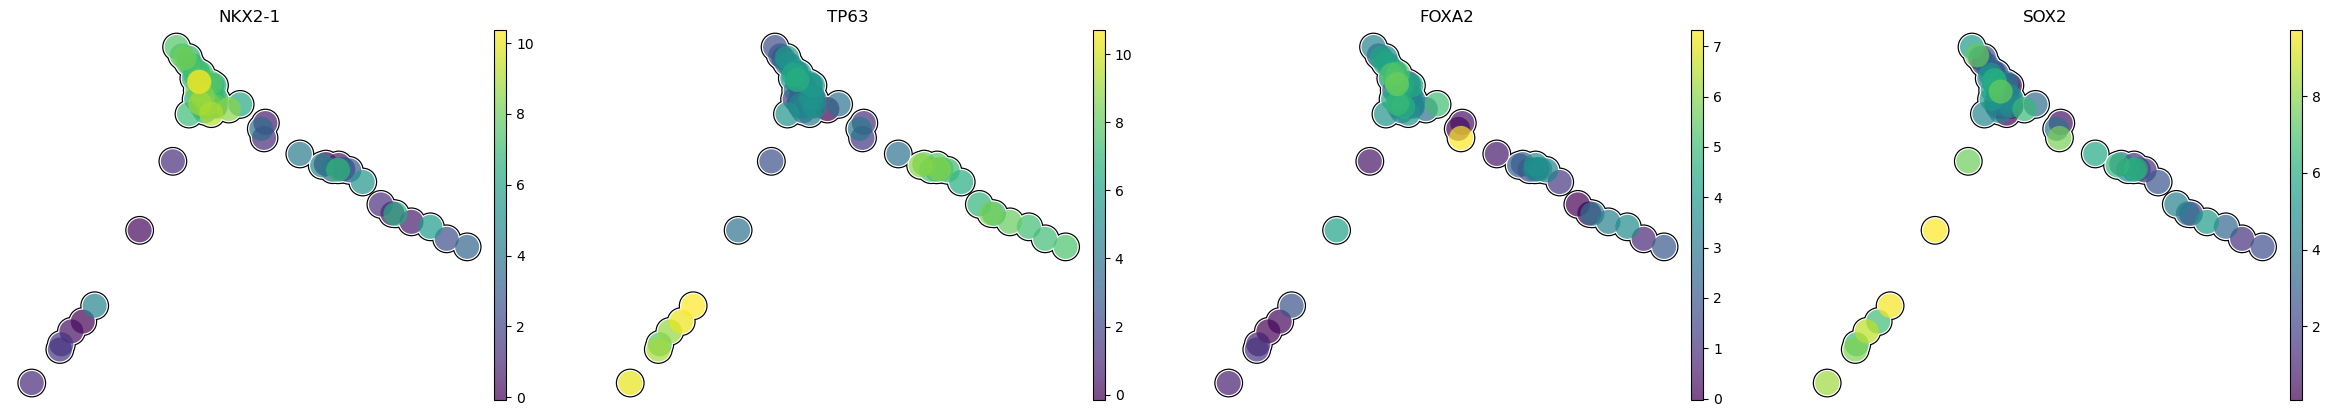

In [143]:
sc.pl.umap(test_adata, color=['NKX2-1', 'TP63', 'FOXA2', 'SOX2'], size=1200, legend_fontsize=16,
           frameon=False, add_outline=True, outline_width=(0.05, 0.05))

/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sibcb1/chenluonanlab8/miaoyuanxiang/miniforge3/envs/GAE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


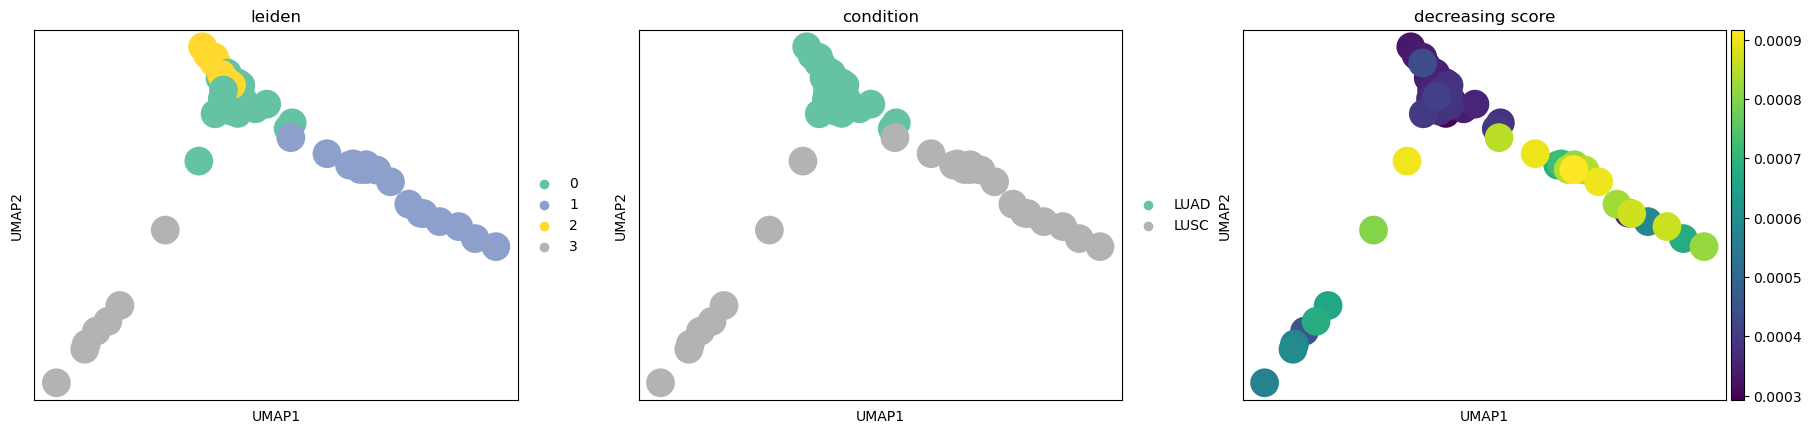

In [208]:
sc.tl.leiden(
    test_adata,
    resolution=0.25,
    random_state=0,
    directed=False,
)

sc.pl.umap(test_adata, color=["leiden", "condition", "decreasing score"], palette="Set2")

### decreasing state transition on PCs

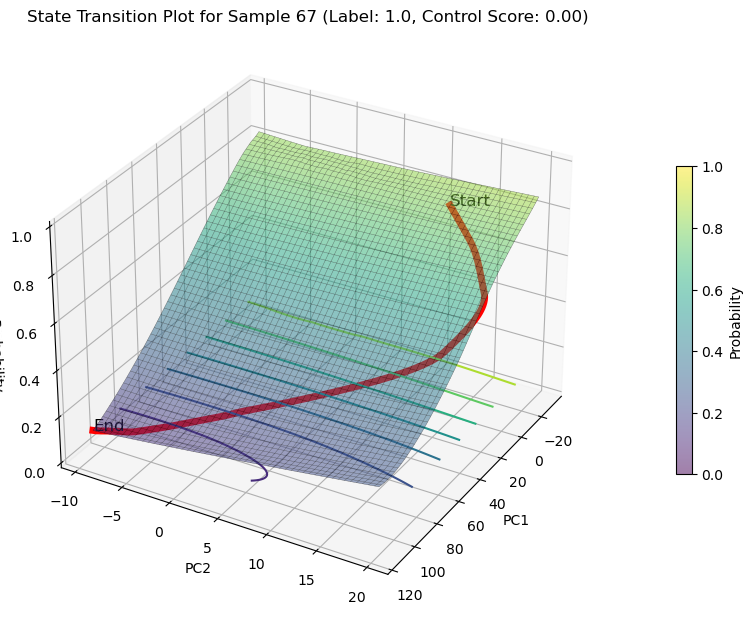

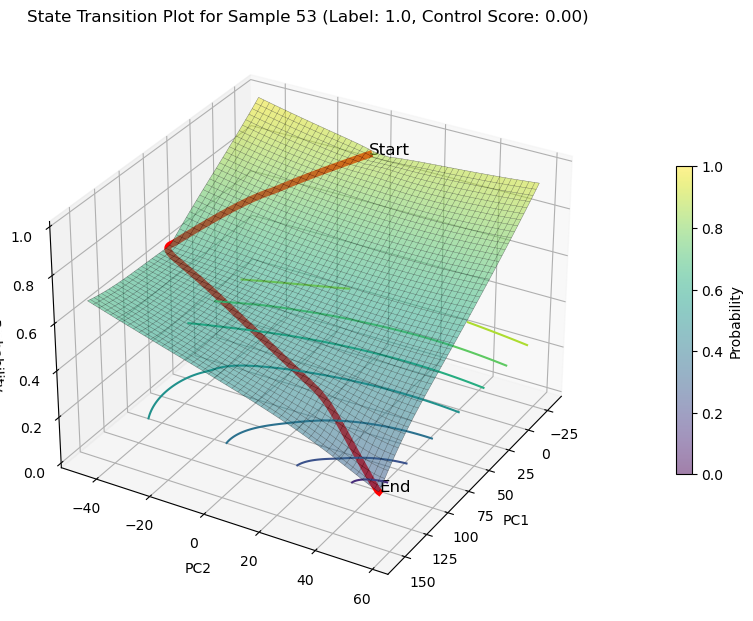

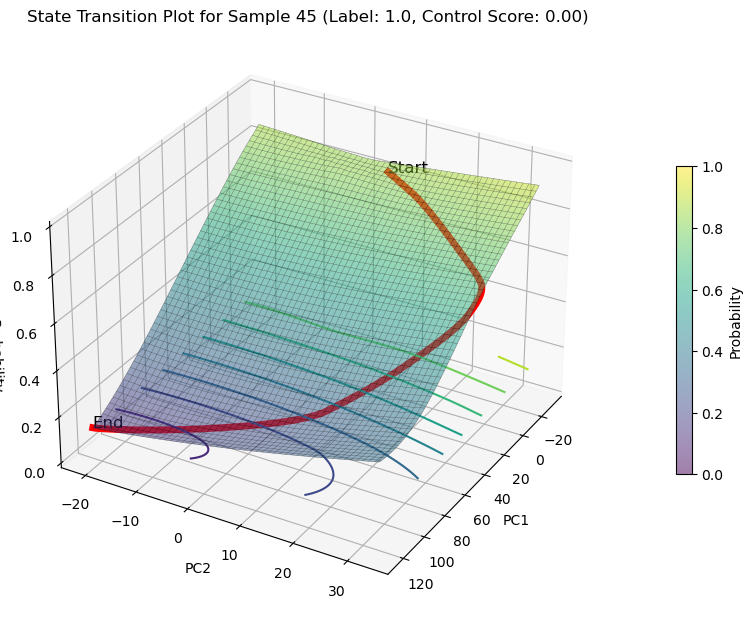

In [220]:
plot_3d_state_transition(adata_decrease, sample_indices=[67,53,45], use_pca=True)

### decreasing state transition on Features(NKX2-1 and SOX2)

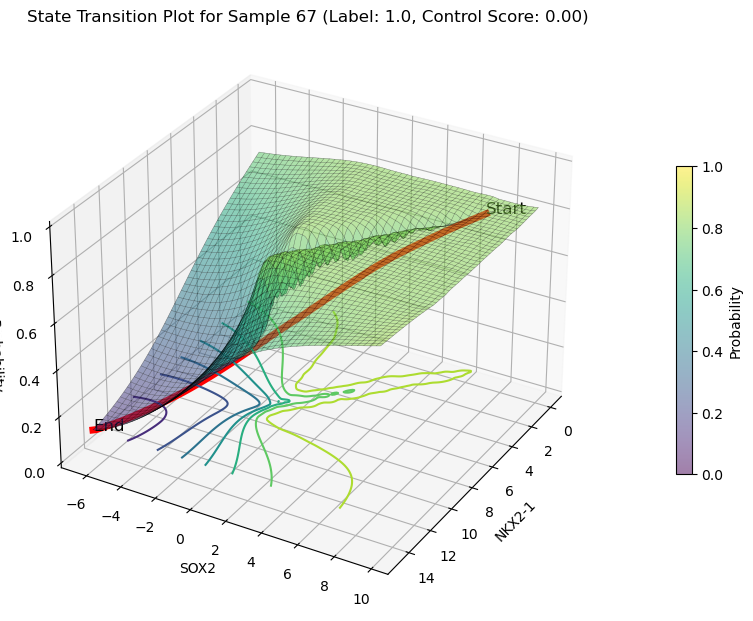

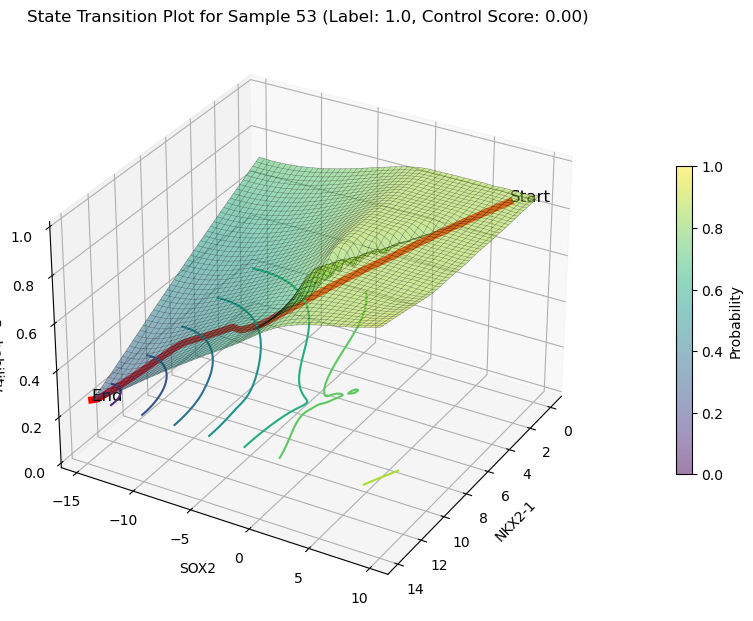

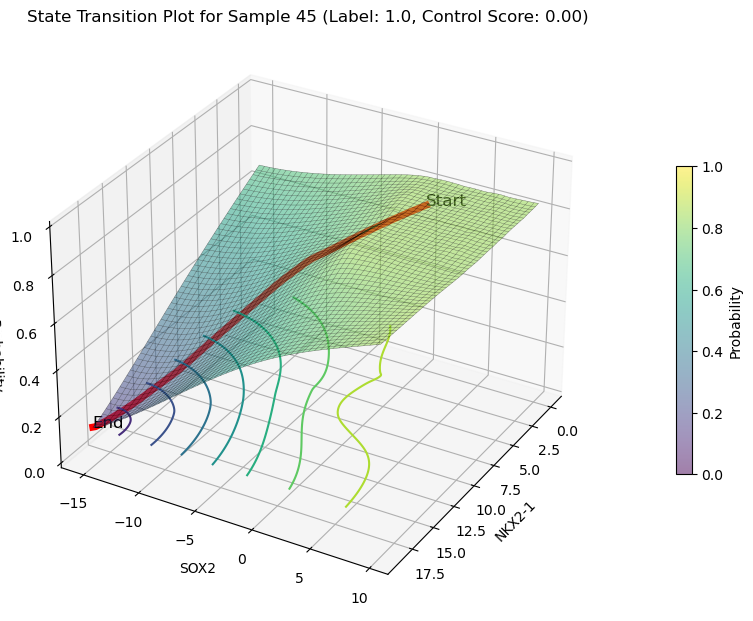

In [227]:
plot_3d_state_transition(adata_decrease, sample_indices=[67,53,45], use_pca=False, feature1='NKX2-1',feature2='SOX2',save_path='/sibcb1/chenluonanlab8/miaoyuanxiang/CauFinder-master/LUAS/human/decrease/')